# Solution Part:
* Data Understanding
* Data Exploration
* Data Cleaning
* Data Preparation/Feature Engineering
* Model Building
* Model Evaluation

In [1]:
#Import all the libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
#Read the dataset
cars = pd.read_parquet('Customer Database.parquet')
cars_test = pd.read_excel('Test Customer Data.xlsx')
cars_test_original = cars_test.copy()

In [6]:
cars.shape

(4265188, 33)

In [7]:
cars.head()

,Location_Region,VRLOCATION,VRSALEAMT,VRMILEAGE,Vehicle_year,Trim,Series,Vehicle_cylinders,Vehicle_botcolor,Vehicle_doors,Vehicle_trantype,Vehicle_engine,Vehicle_drive,Vehicle_condition_drivable,Vehicle_condition_overall,BodyClass,DriveType,EngineHP,FuelTypePrimary,EngineConfiguration,EngineModel,GVWR,PlantCountry,BasePrice,IsEV,EVType,MarketSegment,SALEDATE_WeekofYearNumber,SALEDATE_MonthofYearNumber,SALEDATE_Quarter,SALEDATE_Year,Model,Make
0,EAST,CHARLESTON,1900,4573,2017.0,None,4 passenger,1.0,BLU,2.0,A,1.000000,R,Y,5.0,Low Speed Vehicle (LSV) / Neighborhood Electri...,None,NaN,None,None,None,"Class 1A: 3,000 lb or less (1,360 kg or less)",UNITED STATES (USA),None,0,ICE,Other,2,1,1,2025,2Five,E-Z-GO DIVISION OF TEXTRON
1,WEST,SANANTONIO,4000,12192,1987.0,None,Integral with body cab,NaN,YEL,NaN,A,0.736000,R,Y,4.0,Truck,6x6,NaN,None,V-Shaped,None,"Class 8: 33,001 lb and above (14,969 kg and ab...",UNITED STATES (USA),None,0,ICE,HD Truck,18,5,2,2022,Speciality Vehicle,OSHKOSH
2,WEST,HOUSTON,2900,84304,1984.0,None,V - Series,8.0,TEA,NaN,I,10.422173,R,Y,3.0,Incomplete,4x2,250.0,None,V-Shaped,None,"Class 8: 33,001 lb and above (14,969 kg and ab...",UNITED STATES (USA),None,0,ICE,HD Truck,33,8,3,2022,Speciality Vehicle,OSHKOSH
3,EAST,RICHMOND,79000,29368,2003.0,None,1 1/4 ton HMCS,8.0,None,4.0,A,6.500000,None,None,NaN,Truck,None,NaN,Diesel,V-Shaped,None,"Class 3: 10,001 - 14,000 lb (4,536 - 6,350 kg)",UNITED STATES (USA),None,0,ICE,Other,8,2,1,2022,H1,HUMMER
4,SOUTH,TAMPA,103995,13368,2003.0,None,1 1/4 ton HMCS,8.0,GRY,4.0,A,6.500000,A,Y,NaN,Truck,None,NaN,Diesel,V-Shaped,None,"Class 3: 10,001 - 14,000 lb (4,536 - 6,350 kg)",UNITED STATES (USA),None,0,ICE,Other,45,11,4,2024,H1,HUMMER


In [8]:
cars.dtypes

Location_Region                object
VRLOCATION                     object
VRSALEAMT                       int64
VRMILEAGE                       int64
Vehicle_year                  float64
Trim                           object
Series                         object
Vehicle_cylinders             float32
Vehicle_botcolor               object
Vehicle_doors                 float64
Vehicle_trantype               object
Vehicle_engine                float32
Vehicle_drive                  object
Vehicle_condition_drivable     object
Vehicle_condition_overall     float32
BodyClass                      object
DriveType                      object
EngineHP                      float64
FuelTypePrimary                object
EngineConfiguration            object
EngineModel                    object
GVWR                           object
PlantCountry                   object
BasePrice                      object
IsEV                           object
EVType                         object
MarketSegmen

Data Exploration

In [9]:
# # Step 1: Rename the columns
# cars_test = cars_test.rename(columns={
#     'Vehicle_condition_grade_2': 'Vehicle_condition_overall'
# })

# # Step 2: Format the sale_date as YYYYMMDD
# # cars_test['sale_date'] = pd.to_datetime(cars_test['sale_date'], errors='coerce').dt.strftime('%Y%m%d').astype(int)

# # Step 3: Remove 'Grade ' prefix from the grade column
# cars_test['Vehicle_condition_overall'] = (
#     cars_test['Vehicle_condition_overall']
#         .replace(0.0, np.nan)
# )

# cars['Vehicle_condition_overall'] = (
#     cars['Vehicle_condition_overall']
#         .replace(0.0, np.nan)
# )

In [10]:
def feature_engineering(df):
    df = df.copy()

    # --- basic typing/sanity on numeric inputs you later use as numeric ---
    num_cast_cols = [
        "Vehicle_year","VRMILEAGE","Vehicle_cylinders","Vehicle_condition_overall",
        "EngineHP","BasePrice","SALEDATE_WeekofYearNumber","SALEDATE_MonthofYearNumber",
        "SALEDATE_Quarter","SALEDATE_Year"
    ]
    for c in num_cast_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Fill missing year; cast to int later
    df["Vehicle_year"] = df["Vehicle_year"].fillna(df["Vehicle_year"].median())

    # clamp impossible years (future years cause negative age)
    CURRENT_YEAR = 2025
    df["Vehicle_year"] = df["Vehicle_year"].clip(1900, CURRENT_YEAR).astype(int)

    # Vehicle age
    df["vehicle_age"] = CURRENT_YEAR - df["Vehicle_year"]

    # Guard zero/negative ages before ratios & logs
    # Use 0.5 for 0 or negative ages to avoid div-by-zero/ log issues
    age_safe_for_div = df["vehicle_age"].where(df["vehicle_age"] > 0, 0.5)
    age_safe_for_log = df["vehicle_age"].clip(lower=0)  # log1p(0)=0, avoids -inf

    # Encode drivable
    df["drivable_flag"] = (df["Vehicle_condition_drivable"] == "Y").astype(int)

    # Encode make
    df["make_code"] = df["Make"].astype("category").cat.codes

    # Interactions / ratios (safe)
    df["mileage_age"]      = df["VRMILEAGE"] * df["vehicle_age"]
    df["grade_drivable"]   = df["Vehicle_condition_overall"] * df["drivable_flag"]
    df["mileage_PerYear"]  = df["VRMILEAGE"] / age_safe_for_div

    df["condition_per_age"] = df["Vehicle_condition_overall"] / age_safe_for_div
    df["condition_x_age"]   = df["Vehicle_condition_overall"] * df["vehicle_age"]
    df["cond_log_age"]      = df["Vehicle_condition_overall"] * np.log1p(age_safe_for_log)

    # Buckets (allow out-of-range -> NaN, imputer will handle)
    df["mileage_bucket"] = pd.cut(df["VRMILEAGE"], bins=[0,50_000,100_000,150_000,200_000,300_000], labels=False)
    df["age_bucket"]     = pd.cut(df["vehicle_age"], bins=[0,3,5,8,12,20], labels=False)

    # Final pass: replace inf/-inf (just in case) with NaN; clip absurd magnitudes
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    for c in df.select_dtypes(include=[np.number]).columns:
        df[c] = df[c].clip(-1e9, 1e9)

    return df

In [11]:
cars = feature_engineering(cars)
cars_test = feature_engineering(cars_test)

In [12]:
cars.head()

,Location_Region,VRLOCATION,VRSALEAMT,VRMILEAGE,Vehicle_year,Trim,Series,Vehicle_cylinders,Vehicle_botcolor,Vehicle_doors,Vehicle_trantype,Vehicle_engine,Vehicle_drive,Vehicle_condition_drivable,Vehicle_condition_overall,BodyClass,DriveType,EngineHP,FuelTypePrimary,EngineConfiguration,EngineModel,GVWR,PlantCountry,BasePrice,IsEV,EVType,MarketSegment,SALEDATE_WeekofYearNumber,SALEDATE_MonthofYearNumber,SALEDATE_Quarter,SALEDATE_Year,Model,Make,vehicle_age,drivable_flag,make_code,mileage_age,grade_drivable,mileage_PerYear,condition_per_age,condition_x_age,cond_log_age,mileage_bucket,age_bucket
0,EAST,CHARLESTON,1900,4573,2017,None,4 passenger,1.0,BLU,2.0,A,1.000000,R,Y,5.0,Low Speed Vehicle (LSV) / Neighborhood Electri...,None,NaN,None,None,None,"Class 1A: 3,000 lb or less (1,360 kg or less)",UNITED STATES (USA),NaN,0,ICE,Other,2,1,1,2025,2Five,E-Z-GO DIVISION OF TEXTRON,8,1,59,36584,5.0,571.625000,0.625000,40.0,10.986123,0.0,2.0
1,WEST,SANANTONIO,4000,12192,1987,None,Integral with body cab,NaN,YEL,NaN,A,0.736000,R,Y,4.0,Truck,6x6,NaN,None,V-Shaped,None,"Class 8: 33,001 lb and above (14,969 kg and ab...",UNITED STATES (USA),NaN,0,ICE,HD Truck,18,5,2,2022,Speciality Vehicle,OSHKOSH,38,1,157,463296,4.0,320.842105,0.105263,152.0,14.654247,0.0,NaN
2,WEST,HOUSTON,2900,84304,1984,None,V - Series,8.0,TEA,NaN,I,10.422173,R,Y,3.0,Incomplete,4x2,250.0,None,V-Shaped,None,"Class 8: 33,001 lb and above (14,969 kg and ab...",UNITED STATES (USA),NaN,0,ICE,HD Truck,33,8,3,2022,Speciality Vehicle,OSHKOSH,41,1,157,3456464,3.0,2056.195122,0.073171,123.0,11.213009,1.0,NaN
3,EAST,RICHMOND,79000,29368,2003,None,1 1/4 ton HMCS,8.0,None,4.0,A,6.500000,None,None,NaN,Truck,None,NaN,Diesel,V-Shaped,None,"Class 3: 10,001 - 14,000 lb (4,536 - 6,350 kg)",UNITED STATES (USA),NaN,0,ICE,Other,8,2,1,2022,H1,HUMMER,22,0,92,646096,NaN,1334.909091,NaN,NaN,NaN,0.0,NaN
4,SOUTH,TAMPA,103995,13368,2003,None,1 1/4 ton HMCS,8.0,GRY,4.0,A,6.500000,A,Y,NaN,Truck,None,NaN,Diesel,V-Shaped,None,"Class 3: 10,001 - 14,000 lb (4,536 - 6,350 kg)",UNITED STATES (USA),NaN,0,ICE,Other,45,11,4,2024,H1,HUMMER,22,1,92,294096,NaN,607.636364,NaN,NaN,NaN,0.0,NaN


In [13]:
cars_numeric = cars.select_dtypes(include=[np.number])

In [14]:
cars_numeric.corr()

,VRSALEAMT,VRMILEAGE,Vehicle_year,Vehicle_cylinders,Vehicle_doors,Vehicle_engine,Vehicle_condition_overall,EngineHP,BasePrice,SALEDATE_WeekofYearNumber,SALEDATE_MonthofYearNumber,SALEDATE_Quarter,SALEDATE_Year,vehicle_age,drivable_flag,make_code,mileage_age,grade_drivable,mileage_PerYear,condition_per_age,condition_x_age,cond_log_age,mileage_bucket,age_bucket
VRSALEAMT,1.000000,-0.570491,0.573558,0.226496,-0.018807,0.009821,0.528678,0.476235,0.433910,0.002731,0.002743,0.002666,0.046018,-0.573558,0.066563,-0.006760,-0.534989,0.451927,-0.110286,0.536671,-0.284512,0.076781,-0.575354,-0.615311
VRMILEAGE,-0.570491,1.000000,-0.601813,0.183936,-0.003998,-0.014460,-0.433074,-0.058272,-0.024872,0.002043,0.002104,0.001596,-0.018383,0.601813,-0.110689,0.001624,0.872724,-0.369203,0.466399,-0.454587,0.307660,-0.027193,0.964192,0.611385
Vehicle_year,0.573558,-0.601813,1.000000,-0.198238,0.141250,-0.007685,0.363210,0.187959,0.097889,0.019935,0.019752,0.019244,0.307962,-1.000000,0.226170,-0.006990,-0.842015,0.359555,0.261330,0.575874,-0.725197,-0.246475,-0.596596,-0.921542
Vehicle_cylinders,0.226496,0.183936,-0.198238,1.000000,-0.165640,0.018062,-0.007730,0.774841,0.415405,-0.006338,-0.006305,-0.006209,-0.050308,0.198238,-0.058263,-0.198457,0.217154,-0.012316,0.020828,-0.074289,0.172580,0.093494,0.169926,0.122700
Vehicle_doors,-0.018807,-0.003998,0.141250,-0.165640,1.000000,-0.050508,0.037882,-0.082521,-0.020740,-0.001795,-0.001609,-0.001779,-0.003932,-0.141250,-0.021237,0.085085,-0.077846,0.026767,0.093123,0.034168,-0.092025,-0.016736,0.009467,-0.050115
Vehicle_engine,0.009821,-0.014460,-0.007685,0.018062,-0.050508,1.000000,0.001573,-0.009115,0.377107,0.000362,0.000434,0.000797,0.008494,0.007685,0.001609,-0.006320,-0.004304,-0.001970,-0.021831,-0.001234,0.010045,0.005314,-0.014851,0.001144
Vehicle_condition_overall,0.528678,-0.433074,0.363210,-0.007730,0.037882,0.001573,1.000000,0.113509,0.100447,-0.010475,-0.010198,-0.009828,0.013265,-0.363210,0.262423,0.026655,-0.397893,0.820606,-0.121162,0.468277,0.304160,0.746423,-0.428070,-0.362873
EngineHP,0.476235,-0.058272,0.187959,0.774841,-0.082521,-0.009115,0.113509,1.000000,0.700279,0.001531,0.001549,0.001340,0.067652,-0.187959,0.022990,-0.235561,-0.134399,0.095280,0.097097,0.063322,-0.032063,0.053753,-0.063015,-0.118847
BasePrice,0.433910,-0.024872,0.097889,0.415405,-0.020740,0.377107,0.100447,0.700279,1.000000,0.002592,0.002825,0.002984,0.029690,-0.097889,-0.034241,-0.021395,-0.045619,0.076477,0.006552,0.125437,0.043077,0.075579,-0.026250,-0.135707
SALEDATE_WeekofYearNumber,0.002731,0.002043,0.019935,-0.006338,-0.001795,0.000362,-0.010475,0.001531,0.002592,1.000000,0.996358,0.966832,-0.079765,-0.019935,0.034472,0.001785,-0.011281,0.000532,0.027860,0.007038,-0.008145,-0.012875,0.002391,-0.015310


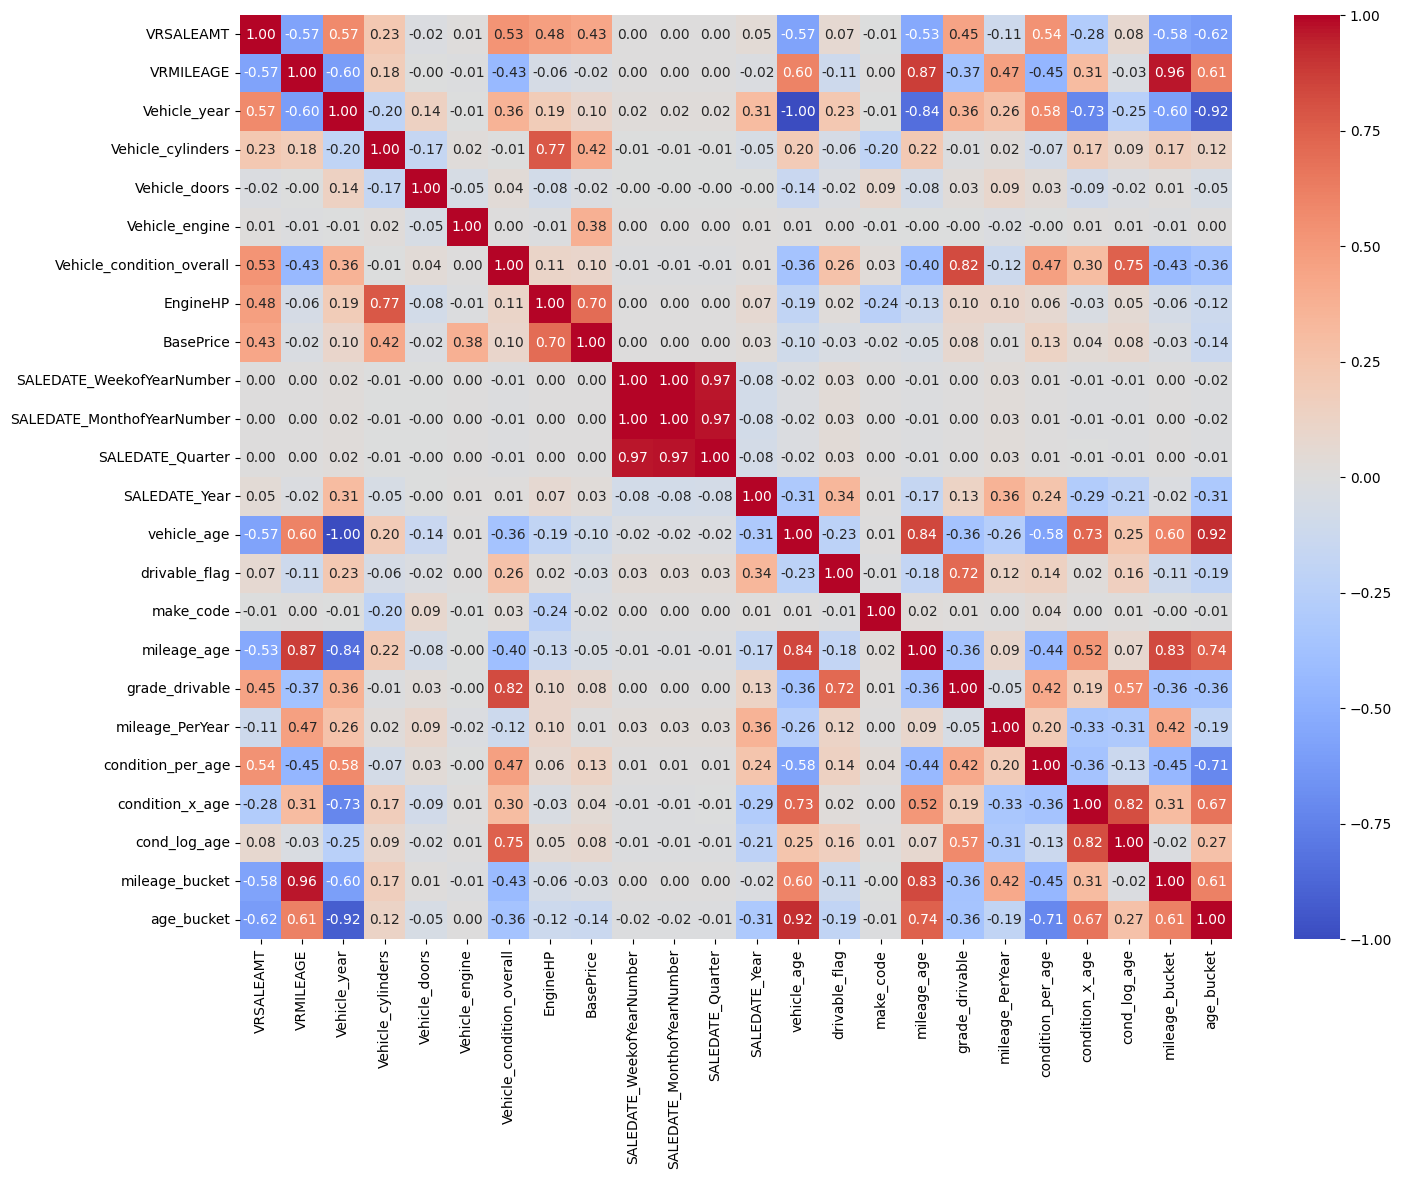

In [15]:
plt.figure(figsize=(16, 12))
sns.heatmap(cars_numeric.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [16]:
#Correlation plot
cor = cars_numeric.corr()
cor

,VRSALEAMT,VRMILEAGE,Vehicle_year,Vehicle_cylinders,Vehicle_doors,Vehicle_engine,Vehicle_condition_overall,EngineHP,BasePrice,SALEDATE_WeekofYearNumber,SALEDATE_MonthofYearNumber,SALEDATE_Quarter,SALEDATE_Year,vehicle_age,drivable_flag,make_code,mileage_age,grade_drivable,mileage_PerYear,condition_per_age,condition_x_age,cond_log_age,mileage_bucket,age_bucket
VRSALEAMT,1.000000,-0.570491,0.573558,0.226496,-0.018807,0.009821,0.528678,0.476235,0.433910,0.002731,0.002743,0.002666,0.046018,-0.573558,0.066563,-0.006760,-0.534989,0.451927,-0.110286,0.536671,-0.284512,0.076781,-0.575354,-0.615311
VRMILEAGE,-0.570491,1.000000,-0.601813,0.183936,-0.003998,-0.014460,-0.433074,-0.058272,-0.024872,0.002043,0.002104,0.001596,-0.018383,0.601813,-0.110689,0.001624,0.872724,-0.369203,0.466399,-0.454587,0.307660,-0.027193,0.964192,0.611385
Vehicle_year,0.573558,-0.601813,1.000000,-0.198238,0.141250,-0.007685,0.363210,0.187959,0.097889,0.019935,0.019752,0.019244,0.307962,-1.000000,0.226170,-0.006990,-0.842015,0.359555,0.261330,0.575874,-0.725197,-0.246475,-0.596596,-0.921542
Vehicle_cylinders,0.226496,0.183936,-0.198238,1.000000,-0.165640,0.018062,-0.007730,0.774841,0.415405,-0.006338,-0.006305,-0.006209,-0.050308,0.198238,-0.058263,-0.198457,0.217154,-0.012316,0.020828,-0.074289,0.172580,0.093494,0.169926,0.122700
Vehicle_doors,-0.018807,-0.003998,0.141250,-0.165640,1.000000,-0.050508,0.037882,-0.082521,-0.020740,-0.001795,-0.001609,-0.001779,-0.003932,-0.141250,-0.021237,0.085085,-0.077846,0.026767,0.093123,0.034168,-0.092025,-0.016736,0.009467,-0.050115
Vehicle_engine,0.009821,-0.014460,-0.007685,0.018062,-0.050508,1.000000,0.001573,-0.009115,0.377107,0.000362,0.000434,0.000797,0.008494,0.007685,0.001609,-0.006320,-0.004304,-0.001970,-0.021831,-0.001234,0.010045,0.005314,-0.014851,0.001144
Vehicle_condition_overall,0.528678,-0.433074,0.363210,-0.007730,0.037882,0.001573,1.000000,0.113509,0.100447,-0.010475,-0.010198,-0.009828,0.013265,-0.363210,0.262423,0.026655,-0.397893,0.820606,-0.121162,0.468277,0.304160,0.746423,-0.428070,-0.362873
EngineHP,0.476235,-0.058272,0.187959,0.774841,-0.082521,-0.009115,0.113509,1.000000,0.700279,0.001531,0.001549,0.001340,0.067652,-0.187959,0.022990,-0.235561,-0.134399,0.095280,0.097097,0.063322,-0.032063,0.053753,-0.063015,-0.118847
BasePrice,0.433910,-0.024872,0.097889,0.415405,-0.020740,0.377107,0.100447,0.700279,1.000000,0.002592,0.002825,0.002984,0.029690,-0.097889,-0.034241,-0.021395,-0.045619,0.076477,0.006552,0.125437,0.043077,0.075579,-0.026250,-0.135707
SALEDATE_WeekofYearNumber,0.002731,0.002043,0.019935,-0.006338,-0.001795,0.000362,-0.010475,0.001531,0.002592,1.000000,0.996358,0.966832,-0.079765,-0.019935,0.034472,0.001785,-0.011281,0.000532,0.027860,0.007038,-0.008145,-0.012875,0.002391,-0.015310


In [17]:
cars.isnull().sum()

Location_Region                     0
VRLOCATION                          0
VRSALEAMT                           0
VRMILEAGE                           0
Vehicle_year                        0
Trim                          1397797
Series                        2512798
Vehicle_cylinders               67558
Vehicle_botcolor               609905
Vehicle_doors                  113701
Vehicle_trantype               466777
Vehicle_engine                  11029
Vehicle_drive                  489152
Vehicle_condition_drivable    1610644
Vehicle_condition_overall     2346056
BodyClass                         372
DriveType                     1104122
EngineHP                      2228930
FuelTypePrimary                111148
EngineConfiguration           1602466
EngineModel                   1882006
GVWR                            10732
PlantCountry                     2182
BasePrice                     3671562
IsEV                                0
EVType                              0
MarketSegmen

Data Preparation

In [18]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute   import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error

In [19]:
cars.head()

,Location_Region,VRLOCATION,VRSALEAMT,VRMILEAGE,Vehicle_year,Trim,Series,Vehicle_cylinders,Vehicle_botcolor,Vehicle_doors,Vehicle_trantype,Vehicle_engine,Vehicle_drive,Vehicle_condition_drivable,Vehicle_condition_overall,BodyClass,DriveType,EngineHP,FuelTypePrimary,EngineConfiguration,EngineModel,GVWR,PlantCountry,BasePrice,IsEV,EVType,MarketSegment,SALEDATE_WeekofYearNumber,SALEDATE_MonthofYearNumber,SALEDATE_Quarter,SALEDATE_Year,Model,Make,vehicle_age,drivable_flag,make_code,mileage_age,grade_drivable,mileage_PerYear,condition_per_age,condition_x_age,cond_log_age,mileage_bucket,age_bucket
0,EAST,CHARLESTON,1900,4573,2017,None,4 passenger,1.0,BLU,2.0,A,1.000000,R,Y,5.0,Low Speed Vehicle (LSV) / Neighborhood Electri...,None,NaN,None,None,None,"Class 1A: 3,000 lb or less (1,360 kg or less)",UNITED STATES (USA),NaN,0,ICE,Other,2,1,1,2025,2Five,E-Z-GO DIVISION OF TEXTRON,8,1,59,36584,5.0,571.625000,0.625000,40.0,10.986123,0.0,2.0
1,WEST,SANANTONIO,4000,12192,1987,None,Integral with body cab,NaN,YEL,NaN,A,0.736000,R,Y,4.0,Truck,6x6,NaN,None,V-Shaped,None,"Class 8: 33,001 lb and above (14,969 kg and ab...",UNITED STATES (USA),NaN,0,ICE,HD Truck,18,5,2,2022,Speciality Vehicle,OSHKOSH,38,1,157,463296,4.0,320.842105,0.105263,152.0,14.654247,0.0,NaN
2,WEST,HOUSTON,2900,84304,1984,None,V - Series,8.0,TEA,NaN,I,10.422173,R,Y,3.0,Incomplete,4x2,250.0,None,V-Shaped,None,"Class 8: 33,001 lb and above (14,969 kg and ab...",UNITED STATES (USA),NaN,0,ICE,HD Truck,33,8,3,2022,Speciality Vehicle,OSHKOSH,41,1,157,3456464,3.0,2056.195122,0.073171,123.0,11.213009,1.0,NaN
3,EAST,RICHMOND,79000,29368,2003,None,1 1/4 ton HMCS,8.0,None,4.0,A,6.500000,None,None,NaN,Truck,None,NaN,Diesel,V-Shaped,None,"Class 3: 10,001 - 14,000 lb (4,536 - 6,350 kg)",UNITED STATES (USA),NaN,0,ICE,Other,8,2,1,2022,H1,HUMMER,22,0,92,646096,NaN,1334.909091,NaN,NaN,NaN,0.0,NaN
4,SOUTH,TAMPA,103995,13368,2003,None,1 1/4 ton HMCS,8.0,GRY,4.0,A,6.500000,A,Y,NaN,Truck,None,NaN,Diesel,V-Shaped,None,"Class 3: 10,001 - 14,000 lb (4,536 - 6,350 kg)",UNITED STATES (USA),NaN,0,ICE,Other,45,11,4,2024,H1,HUMMER,22,1,92,294096,NaN,607.636364,NaN,NaN,NaN,0.0,NaN


In [20]:
categorical_cols = cars.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical:", categorical_cols)

Categorical: ['Location_Region', 'VRLOCATION', 'Trim', 'Series', 'Vehicle_botcolor', 'Vehicle_trantype', 'Vehicle_drive', 'Vehicle_condition_drivable', 'BodyClass', 'DriveType', 'FuelTypePrimary', 'EngineConfiguration', 'EngineModel', 'GVWR', 'PlantCountry', 'IsEV', 'EVType', 'MarketSegment', 'Model', 'Make']


In [28]:
# remove engine from your list of categoricals...
categorical_feats = [
    'Location_Region','VRLOCATION','Vehicle_botcolor','Vehicle_trantype','Vehicle_drive','Vehicle_condition_drivable','Make','Model','Trim','Series', 
    'BodyClass', 'DriveType', 'FuelTypePrimary', 'EngineConfiguration', 'EngineModel', 'GVWR', 'PlantCountry', 'EVType', 'MarketSegment'
]
# …and add it into numeric_feats
numeric_feats = [
    'VRMILEAGE','Vehicle_year','Vehicle_cylinders','Vehicle_condition_overall','vehicle_age','drivable_flag', 'make_code', 'mileage_age','grade_drivable','mileage_bucket','age_bucket','EngineHP','BasePrice','SALEDATE_WeekofYearNumber','SALEDATE_MonthofYearNumber',
	'SALEDATE_Quarter','SALEDATE_Year','mileage_PerYear','condition_per_age','condition_x_age','cond_log_age'
]


In [29]:
from scipy.stats import skew
skewness = skew(cars['Vehicle_condition_overall'].dropna())
print("Skewness:", skewness)

Skewness: -0.3227299153804779


In [30]:
X_external = cars_test[numeric_feats + categorical_feats]

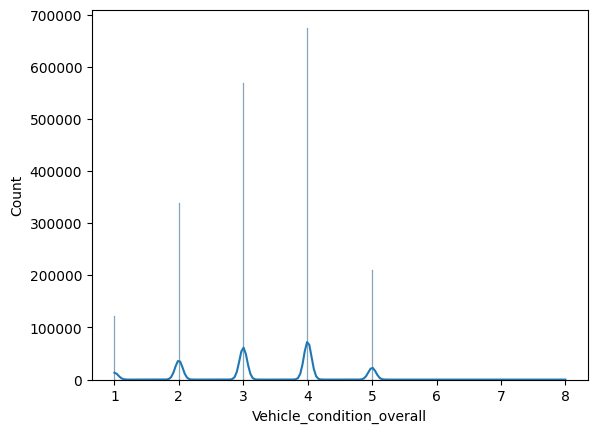

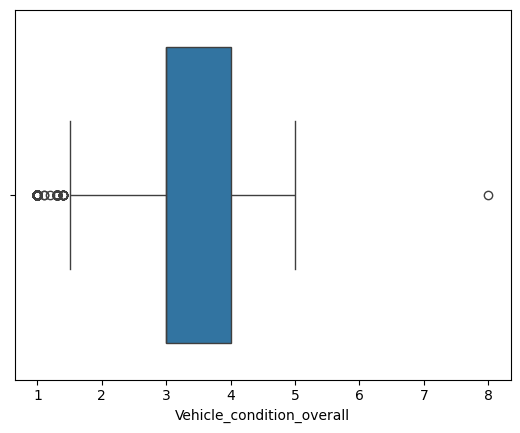

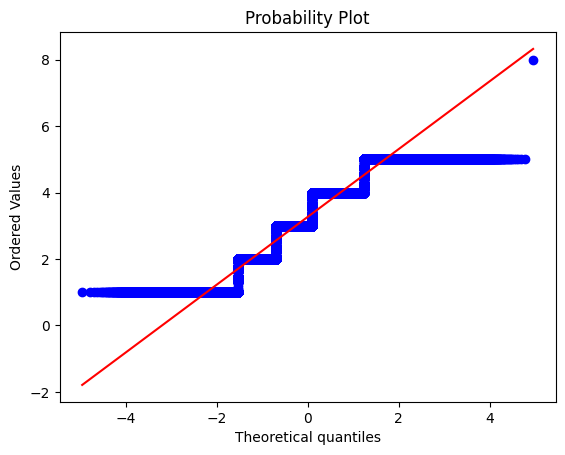

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.histplot(cars['Vehicle_condition_overall'], kde=True)
plt.show()

sns.boxplot(x=cars['Vehicle_condition_overall'])
plt.show()

stats.probplot(cars['Vehicle_condition_overall'].dropna(), dist="norm", plot=plt)
plt.show()

In [32]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scale',   StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown', add_indicator=True)),
    ('ohe',      OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_feats),
    ('cat', cat_pipe, categorical_feats),
], remainder='drop', sparse_threshold=1.0)

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [34]:
X = cars[numeric_feats + categorical_feats]
y = cars['VRSALEAMT']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.01, random_state=42
)

In [35]:
# 4. Helper to build a full pipeline + extract coef names
def make_model_pipeline(model, poly=False):
    steps = []
    if poly:
        # expand numeric features to polynomial degree 2
        steps.append(('poly', PolynomialFeatures(degree=2, include_bias=False)))
    steps.append(('preproc', preprocessor))
    steps.append(('reg', model))
    return Pipeline(steps)

def get_feature_names(pipeline):
    """
    After fitting, get the transformed feature names in order, so you can map back to coefficients.
    Requires sklearn ≥ 1.0 for ColumnTransformer.get_feature_names_out.
    """
    # name from the 'preproc' step
    feat_names = pipeline.named_steps['preproc'].get_feature_names_out()
    if 'poly' in pipeline.named_steps:
        # if polynomial, get names from poly step
        feat_names = pipeline.named_steps['poly'].get_feature_names_out(feat_names)
    return feat_names

In [36]:
# # Linear Regression

# lin_pipe = make_model_pipeline(LinearRegression())
# lin_pipe.fit(X_train, y_train)
# lin_preds = lin_pipe.predict(X_test)

# lin_r2 = r2_score(y_test, lin_preds)
# lin_mae = mean_absolute_error(y_test, lin_preds)
# lin_mse = mean_squared_error(y_test, lin_preds)
# lin_rmse = np.sqrt(lin_mse)
# lin_mape = mean_absolute_percentage_error(y_test, lin_preds)

# lin_feat_names = get_feature_names(lin_pipe)
# lin_coefs = lin_pipe.named_steps['reg'].coef_
# lin_coef_df = pd.DataFrame({'feature': lin_feat_names, 'coef': lin_coefs}).sort_values(by='coef', key=lambda x: x.abs(), ascending=False)

In [37]:
# #Lasso Regression (α=0.5)
# lasso_pipe = make_model_pipeline(Lasso(alpha=0.5, max_iter=10_000))
# lasso_pipe.fit(X_train, y_train)
# lasso_preds = lasso_pipe.predict(X_test)

# lasso_r2 = r2_score(y_test, lasso_preds)
# lasso_mae = mean_absolute_error(y_test, lasso_preds)
# lasso_mse = mean_squared_error(y_test, lasso_preds)
# lasso_rmse = np.sqrt(lasso_mse)
# lasso_mape = mean_absolute_percentage_error(y_test, lasso_preds)

# lasso_feat_names = get_feature_names(lasso_pipe)
# lasso_coefs = lasso_pipe.named_steps['reg'].coef_
# lasso_coef_df = pd.DataFrame({'feature': lasso_feat_names, 'coef': lasso_coefs}).sort_values(by='coef', key=lambda x: x.abs(), ascending=False)

In [38]:
# # Ridge Regression (α=0.5)
# ridge_pipe = make_model_pipeline(Ridge(alpha=0.5))
# ridge_pipe.fit(X_train, y_train)
# ridge_preds = ridge_pipe.predict(X_test)

# ridge_r2 = r2_score(y_test, ridge_preds)
# ridge_mae = mean_absolute_error(y_test, ridge_preds)
# ridge_mse = mean_squared_error(y_test, ridge_preds)
# ridge_rmse = np.sqrt(ridge_mse)
# ridge_mape = mean_absolute_percentage_error(y_test, ridge_preds)

# ridge_feat_names = get_feature_names(ridge_pipe)
# ridge_coefs = ridge_pipe.named_steps['reg'].coef_
# ridge_coef_df = pd.DataFrame({'feature': ridge_feat_names, 'coef': ridge_coefs}).sort_values(by='coef', key=lambda x: x.abs(), ascending=False)

In [39]:
# # For polynomial model only
# poly_num_pipe = Pipeline([
#     ('imputer', SimpleImputer(strategy='median')),
#     ('poly', PolynomialFeatures(degree=2, include_bias=False)),
#     ('scale', StandardScaler())
# ])

# cat_pipe = Pipeline([
#     ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown', add_indicator=True)),
#     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
# ])

# poly_preprocessor = ColumnTransformer([
#     ('num', poly_num_pipe, numeric_feats),
#     ('cat', cat_pipe, categorical_feats),
# ], remainder='drop', sparse_threshold=1.0)

# poly_pipe = Pipeline([
#     ('preproc', poly_preprocessor),
#     ('reg', LinearRegression())
# ])

# poly_pipe.fit(X_train, y_train)
# poly_preds = poly_pipe.predict(X_test)

# poly_r2 = r2_score(y_test, poly_preds)
# poly_mae = mean_absolute_error(y_test, poly_preds)
# poly_mse = mean_squared_error(y_test, poly_preds)
# poly_rmse = np.sqrt(poly_mse)
# poly_mape = mean_absolute_percentage_error(y_test, poly_preds)

# poly_feat_names = poly_pipe.named_steps['preproc'].get_feature_names_out()
# poly_coefs = poly_pipe.named_steps['reg'].coef_
# poly_coef_df = pd.DataFrame({'feature': poly_feat_names, 'coef': poly_coefs}).sort_values(by='coef', key=lambda x: x.abs(), ascending=False)

In [40]:
# # Results
# def print_results(name, r2, mae, mse, rmse, mape, coef_df):
#     print(f"\n=== {name} ===")
#     print("Metrics:")
#     print(f"  R2:   {r2:.4f}")
#     print(f"  MAE:  {mae:.4f}")
#     print(f"  MSE:  {mse:.4f}")
#     print(f"  RMSE: {rmse:.4f}")
#     print(f"  MAPE: {mape:.4f}")
#     print("\nTop coefficients:")
#     print(coef_df.head(10).to_string(index=False))
    
# print_results("Linear", lin_r2, lin_mae, lin_mse, lin_rmse, lin_mape, lin_coef_df)

In [41]:
# print_results("Lasso α=0.5", lasso_r2, lasso_mae, lasso_mse, lasso_rmse, lasso_mape, lasso_coef_df)

In [42]:
# print_results("Ridge α=0.5", ridge_r2, ridge_mae, ridge_mse, ridge_rmse, ridge_mape, ridge_coef_df)

In [43]:
# print_results("Polynomial Degree=2", poly_r2, poly_mae, poly_mse, poly_rmse, poly_mape, poly_coef_df)

In [44]:
from sklearn.compose import TransformedTargetRegressor

def with_log_target(pipeline_or_estimator):
    return TransformedTargetRegressor(
        regressor=pipeline_or_estimator,
        func=np.log1p,      # y' = log(1 + y)
        inverse_func=np.expm1  # y = exp(y') - 1
    )

XGBoost

In [45]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from bayes_opt import BayesianOptimization
from sklearn.metrics import r2_score

In [46]:
# def xgb_evaluate(max_depth, learning_rate, subsample, colsample_bytree, gamma, min_child_weight, reg_alpha, reg_lambda, n_jobs=-1):    
#     max_depth = int(max_depth)
#     min_child_weight = int(min_child_weight)

#     model = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         eval_metric='rmse',
#         use_label_encoder=False,
#         random_state=0,
#         n_estimators=200,
#         max_depth=max_depth,
#         learning_rate=learning_rate,
#         subsample=subsample,
#         colsample_bytree=colsample_bytree,
#         gamma=gamma,
#         min_child_weight=min_child_weight,
#         reg_alpha=reg_alpha,
#         reg_lambda=reg_lambda,
#         n_jobs=n_jobs
# )
    
#     xgb_pipeline = Pipeline([
#         ('preproc', preprocessor),
#         ('xgb',     model)
#     ])

#     xgb_pipeline.fit(X_train, y_train)

#     y_pred = xgb_pipeline.predict(X_test)

#     return r2_score(y_test, y_pred)

# pbounds = {
#     'max_depth': (3, 10),                
#     'learning_rate': (0.01, 0.5),        
#     'subsample': (0.5, 1.0),             
#     'colsample_bytree': (0.5, 1.0),      
#     'gamma': (0, 5),                    
#     'min_child_weight': (1, 10),        
#     'reg_alpha': (0, 1),                
#     'reg_lambda': (0, 5)                
# }


# optimizer = BayesianOptimization(
#     f=xgb_evaluate,        
#     pbounds=pbounds,      
#     random_state=42,       
#     verbose=2              
# )

# optimizer.maximize(init_points=5, n_iter=100)

# print('The best Hyperparameters:', optimizer.max['params'])
# print('The best Accuracy: {:.4f}'.format(optimizer.max['target']))


In [ ]:
import optuna
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

def objective(trial):
    # 1) sample hyperparams
    max_depth         = trial.suggest_int("max_depth", 3, 10)
    learning_rate     = trial.suggest_float("learning_rate", 0.01, 0.5)
    subsample         = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree  = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    gamma             = trial.suggest_float("gamma", 0.0, 5.0)
    min_child_weight  = trial.suggest_int("min_child_weight", 1, 10)
    reg_alpha         = trial.suggest_float("reg_alpha", 0.0, 1.0)
    reg_lambda         = trial.suggest_float("reg_lambda", 0.0, 5.0)
    # n_jobs can stay fixed at -1, or you could expose it too

    # 2) build model + pipeline
    model = XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        use_label_encoder=False,
        random_state=0,
        n_estimators=200,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        min_child_weight=min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        n_jobs=-1
    )
    pipe = Pipeline([
        ('preproc', preprocessor),
        ('xgb',      model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    return r2_score(y_test, y_pred)

# 4) create study & optimize
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=1)

print("Best R²: {:.4f}".format(study.best_value))
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-10-22 14:50:45,414] A new study created in memory with name: no-name-1ad153c9-f48b-4f20-8c10-a43a39a2bd3a
[I 2025-10-22 14:51:46,234] Trial 0 finished with value: 0.9326906800270081 and parameters: {'max_depth': 5, 'learning_rate': 0.4758500101408589, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'gamma': 0.7800932022121826, 'min_child_weight': 2, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 4.330880728874676}. Best is trial 0 with value: 0.9326906800270081.
[I 2025-10-22 14:52:49,697] Trial 1 finished with value: 0.9399518370628357 and parameters: {'max_depth': 7, 'learning_rate': 0.35695556312006227, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'gamma': 4.162213204002109, 'min_child_weight': 3, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.9170225492671691}. Best is trial 1 with value: 0.9399518370628357.
[I 2025-10-22 14:53:51,183] Trial 2 finished with value: 0.9301652908325195 and parameters: {'max_depth': 5, 'l

In [43]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown', add_indicator=True)),
    ('ohe',      OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_feats),
    ('cat', cat_pipe, categorical_feats),
], remainder='drop', sparse_threshold=1.0)

In [44]:
xgb_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('xgb', XGBRegressor(
        # fixed hyperparameters from BayesOpt:
        max_depth=10,
        learning_rate=0.23015076823900443,
        subsample=0.8341201918831133,
        colsample_bytree=0.5765376867979625,
        gamma=4.185277055066359,
        min_child_weight=8,
        reg_alpha=0.7044268055679584,
        reg_lambda=3.8722650249047175,
        # keep the rest as before:
        objective='reg:squarederror',
        eval_metric='rmse',
        use_label_encoder=False,
        random_state=0,
        n_estimators=200,
        n_jobs=-1
    ))
])

xgb_pipeline_ttr = with_log_target(xgb_pipeline)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = cross_val_score(
#     xgb_pipeline,
#     X_train,
#     y_train,
#     cv=kf,
#     scoring="r2",
#     n_jobs=-1,
#     verbose=1
# )
# print("5-Fold CV R² scores:", cv_scores)
# print("Mean CV R²: {:.4f} ± {:.4f}".format(cv_scores.mean(), cv_scores.std()))

In [45]:
# 3. Fit & predict just like before
xgb_pipeline_ttr.fit(X_train, y_train)
xgb_predictions = xgb_pipeline_ttr.predict(X_test)
xgb_predictions_external = xgb_pipeline_ttr.predict(X_external)

In [46]:
xgb_r2 = r2_score(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_predictions)

# Display results
print("📊 XGBoost Regression Evaluation Metrics")
print(f"R² Score  : {xgb_r2:.4f}")
print(f"MAE       : {xgb_mae:.2f}")
print(f"MSE       : {xgb_mse:.2f}")
print(f"RMSE      : {xgb_rmse:.2f}")
print(f"MAPE      : {xgb_mape:.2%}")

📊 XGBoost Regression Evaluation Metrics
R² Score  : 0.9436
MAE       : 1665.24
MSE       : 7671183.50
RMSE      : 2769.69
MAPE      : 28.25%


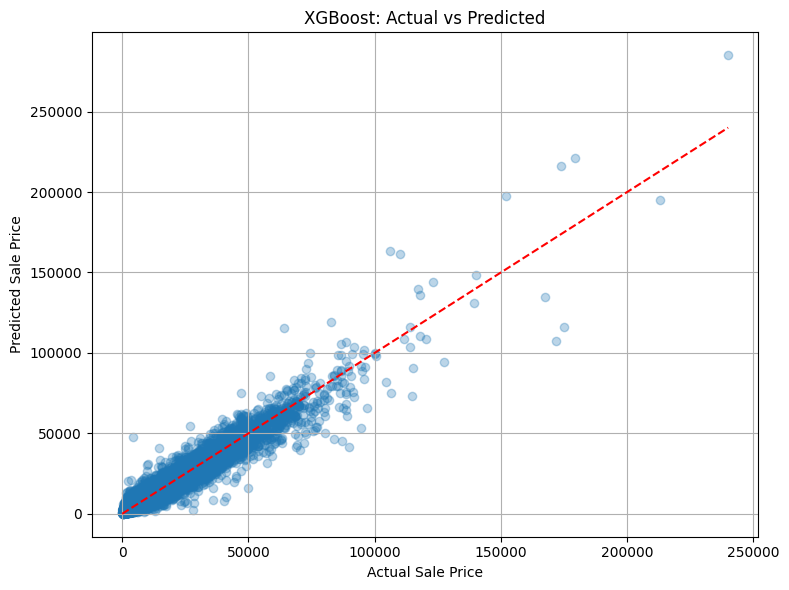

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, xgb_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('XGBoost: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
import shap
import matplotlib.pyplot as plt

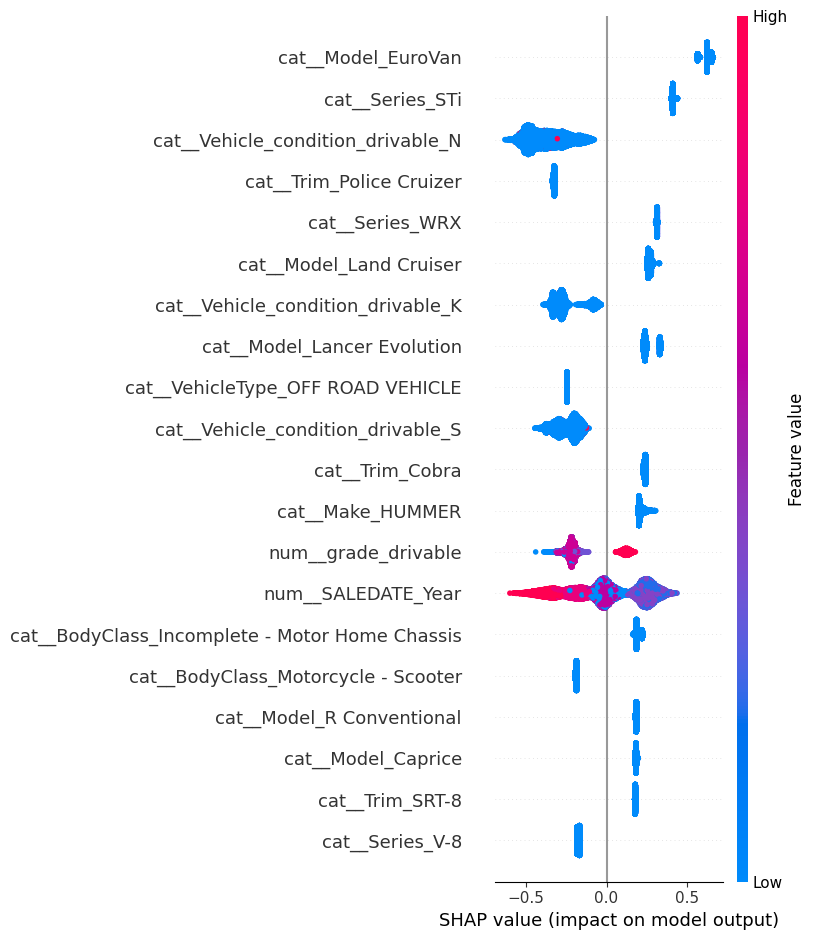

In [49]:
import shap
import scipy.sparse as sp

# ---- after you've fit: xgb_pipeline_ttr.fit(X_train, y_train) ----

# 1) unwrap the fitted inner pipeline
inner = xgb_pipeline_ttr.regressor_                  # this is your Pipeline(preproc -> xgb)
preproc = inner.named_steps['preproc']
fitted_xgb = inner.named_steps['xgb']

# 2) transform X_test using the fitted preprocessor
X_test_trans = preproc.transform(X_test)

# SHAP prefers dense arrays for many explainers; make dense if needed
if sp.issparse(X_test_trans):
    X_test_trans = X_test_trans.toarray()

# 3) feature names that exactly match transformed columns
feature_names = preproc.get_feature_names_out()

# 4) SHAP TreeExplainer on the trained XGBRegressor
explainer = shap.TreeExplainer(fitted_xgb)
shap_values = explainer.shap_values(X_test_trans)

# 5) summary plot
shap.summary_plot(shap_values, X_test_trans, feature_names=feature_names)

In [50]:
import scipy.sparse as sp

# grab the first row of your transformed test set
first_row_sparse = X_test_trans[0]

# convert to a 1-D numpy array
if sp.issparse(first_row_sparse):
    first_row = first_row_sparse.toarray().flatten()
else:
    first_row = first_row_sparse

# now do the force plot
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    first_row,
    feature_names=feature_names
)

CatBoost

In [51]:
# from catboost import CatBoostRegressor
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import r2_score
# from bayes_opt import BayesianOptimization

# def catb_evaluate(depth, learning_rate, subsample, rsm, l2_leaf_reg, n_jobs=-1):
#     # cast integer params
#     depth = int(depth)
#     l2_leaf_reg = max(1.0, l2_leaf_reg)  # ensure >0

#     model = CatBoostRegressor(
#         iterations=200,
#         depth=depth,
#         learning_rate=learning_rate,
#         subsample=subsample,         # requires bootstrap_type='Bernoulli'
#         rsm=rsm,                     # feature subsample fraction
#         l2_leaf_reg=l2_leaf_reg,     # L2 regularization
#         bootstrap_type='Bernoulli',
#         random_seed=0,
#         eval_metric='RMSE',
#         silent=True,
#         thread_count=n_jobs
#     )
    
#     catboost_pipeline = Pipeline([
#         ('preproc', preprocessor),
#         ('catb',    model)
#     ])
    
#     # fit & eval
#     catboost_pipeline.fit(X_train, y_train)
#     catboost_preds = catboost_pipeline.predict(X_test)
    
#     return r2_score(y_test, catboost_preds)


# # define search space (mapping subsample→bagging, rsm→colsample)
# pbounds = {
#     'depth':         (3, 10),
#     'learning_rate': (0.01, 0.3),
#     'subsample':     (0.5, 1.0),
#     'rsm':           (0.5, 1.0),
#     'l2_leaf_reg':   (1, 10),
# }

# optimizer = BayesianOptimization(
#     f=catb_evaluate,
#     pbounds=pbounds,
#     random_state=42,
#     verbose=2
# )

# optimizer.maximize(init_points=5, n_iter=100)

# print("Best params:", optimizer.max['params'])
# print("Best R²: {:.4f}".format(optimizer.max['target']))


In [52]:
# import optuna
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import r2_score
# from catboost import CatBoostRegressor

# def objective(trial):
#     # 1) sample hyperparams
#     depth            = trial.suggest_int("depth", 3, 10)
#     learning_rate    = trial.suggest_float("learning_rate", 1e-3, 0.3, log=True)
#     rsm              = trial.suggest_float("rsm", 0.5, 1.0)
#     l2_leaf_reg      = trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True)
#     random_strength  = trial.suggest_float("random_strength", 0.0, 2.0)
#     min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1, 64)
#     bootstrap_type   = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])

#     # Set only the compatible stochasticity parameter
#     params = dict(
#         loss_function='RMSE',
#         eval_metric='RMSE',
#         iterations=1000,             # high, but early stopping will cut off
#         depth=depth,
#         learning_rate=learning_rate,
#         rsm=rsm,
#         l2_leaf_reg=l2_leaf_reg,
#         random_strength=random_strength,
#         min_data_in_leaf=min_data_in_leaf,
#         bootstrap_type=bootstrap_type,
#         random_state=42,
#         verbose=0,
#         allow_writing_files=False,
#         thread_count=-1,             # use all CPU cores
#     )

#     if bootstrap_type == "Bayesian":
#         params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)
#         # DO NOT set subsample here
#     elif bootstrap_type == "Bernoulli":
#         params["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)
#         # DO NOT set bagging_temperature here
#     else:  # MVS
#         # Neither subsample nor bagging_temperature applies
#         pass

#     # 2) build model + pipeline
#     model = CatBoostRegressor(**params)

#     pipe = Pipeline([
#         ('preproc', preprocessor),
#         ('cat',     model)
#     ])

#     pipe.fit(X_train, y_train)
#     y_pred = pipe.predict(X_test)

#     return r2_score(y_test, y_pred)

# # 4) create study & optimize
# study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
# study.optimize(objective, n_trials=50, n_jobs=1)

# print("Best R²: {:.4f}".format(study.best_value))
# print("Best hyperparameters:")
# for k, v in study.best_params.items():
#     print(f"  {k}: {v}")

In [53]:
from catboost import CatBoostRegressor
catboost_model = CatBoostRegressor(
    iterations= 300,
    learning_rate= 0.07970813993595934,
    depth= int(10.0),
    rsm= 0.7660893833138341,
    l2_leaf_reg= 0.6193707955150439,
    random_strength = 1.3242384708136643,
    min_data_in_leaf = 1,
    subsample = 0.9769453707501106,
    bootstrap_type = 'Bernoulli',
    loss_function='RMSE',
    verbose=0,
    random_state=42
)

In [54]:
from sklearn.pipeline import Pipeline

catboost_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('catboost', catboost_model)
])

catboost_pipeline_ttr = with_log_target(catboost_pipeline)

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = cross_val_score(
#     catboost_pipeline,
#     X_train,
#     y_train,
#     cv=kf,
#     scoring="r2",
#     n_jobs=-1,
#     verbose=1
# )
# print("5-Fold CV R² scores:", cv_scores)
# print("Mean CV R²: {:.4f} ± {:.4f}".format(cv_scores.mean(), cv_scores.std()))

In [55]:
# Fit the pipeline
catboost_pipeline_ttr.fit(X_train, y_train)

# Predict on test data
catboost_preds = catboost_pipeline_ttr.predict(X_test)
catboost_preds_external = catboost_pipeline_ttr.predict(X_external)

In [56]:
catboost_r2 = r2_score(y_test, catboost_preds)
catboost_mae = mean_absolute_error(y_test, catboost_preds)
catboost_mse = mean_squared_error(y_test, catboost_preds)
catboost_rmse = np.sqrt(catboost_mse)
catboost_mape = mean_absolute_percentage_error(y_test, catboost_preds)

# Display results
print("📊 catboost Regression Evaluation Metrics")
print(f"R² Score  : {catboost_r2:.4f}")
print(f"MAE       : {catboost_mae:.2f}")
print(f"MSE       : {catboost_mse:.2f}")
print(f"RMSE      : {catboost_rmse:.2f}")
print(f"MAPE      : {catboost_mape:.2%}")

📊 catboost Regression Evaluation Metrics
R² Score  : 0.9243
MAE       : 1883.58
MSE       : 10307261.60
RMSE      : 3210.49
MAPE      : 30.62%


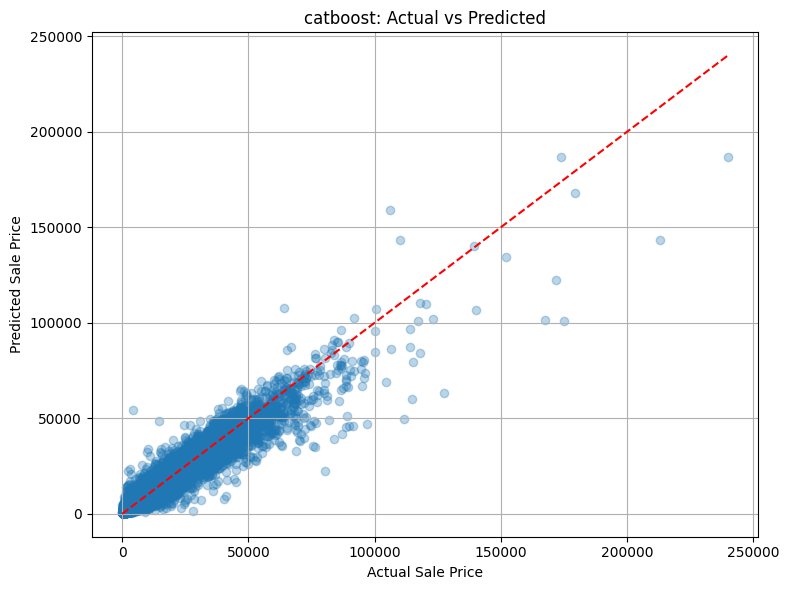

In [57]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, catboost_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('catboost: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

CatBoost Native Handling

In [58]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [59]:
categorical_feats = list(pd.Index(categorical_feats).unique())
numeric_feats     = list(pd.Index(numeric_feats).unique())
all_feats         = categorical_feats + numeric_feats  # order matters for indices

In [60]:
X_train_all    = X_train[all_feats].copy()
X_test_all     = X_test[all_feats].copy()
X_external_all = X_external[all_feats].copy()


In [61]:
# 2) Fill/convert categorical columns on ALL splits
def prep_cats(df, cat_cols):
    # Fill NaN, then cast to string/object (CatBoost wants strings/ints, not floats/NaN)
    df[cat_cols] = df[cat_cols].fillna('Unknown').astype(str)
    return df

X_train_all    = prep_cats(X_train_all,    categorical_feats)
X_test_all     = prep_cats(X_test_all,     categorical_feats)
X_external_all = prep_cats(X_external_all, categorical_feats)

In [ ]:
# 3) Cat feature indices must match the columns you pass into Pool
cat_feature_indices = [all_feats.index(c) for c in categorical_feats]

# 4) Train on log-target and predict
y_train_log = np.log1p(y_train)

train_pool = Pool(X_train_all, y_train_log, cat_features=cat_feature_indices)
test_pool  = Pool(X_test_all,  cat_features=cat_feature_indices)
ext_pool   = Pool(X_external_all, cat_features=cat_feature_indices)

In [64]:
cat_model = CatBoostRegressor(
    iterations= 300,
    learning_rate= 0.07970813993595934,
    depth= int(10.0),
    rsm= 0.7660893833138341,
    l2_leaf_reg= 0.6193707955150439,
    random_strength = 1.3242384708136643,
    min_data_in_leaf = 1,
    subsample = 0.9769453707501106,
    bootstrap_type = 'Bernoulli',
    loss_function='RMSE',
    verbose=0,
    random_state=42
)

cat_model.fit(train_pool)

In [65]:
cat_log_preds          = cat_model.predict(test_pool)
cat_preds              = np.expm1(cat_log_preds)

cat_log_preds_external = cat_model.predict(ext_pool)
cat_preds_external     = np.expm1(cat_log_preds_external)

In [66]:
cat_r2 = r2_score(y_test, cat_preds)
cat_mae = mean_absolute_error(y_test, cat_preds)
cat_mse = mean_squared_error(y_test, cat_preds)
cat_rmse = np.sqrt(cat_mse)
cat_mape = mean_absolute_percentage_error(y_test, cat_preds)

# Display results
print("📊 catboost Regression Evaluation Metrics")
print(f"R² Score  : {cat_r2:.4f}")
print(f"MAE       : {cat_mae:.2f}")
print(f"MSE       : {cat_mse:.2f}")
print(f"RMSE      : {cat_rmse:.2f}")
print(f"MAPE      : {cat_mape:.2%}")

📊 catboost Regression Evaluation Metrics
R² Score  : 0.9442
MAE       : 1665.21
MSE       : 7592092.30
RMSE      : 2755.38
MAPE      : 28.22%


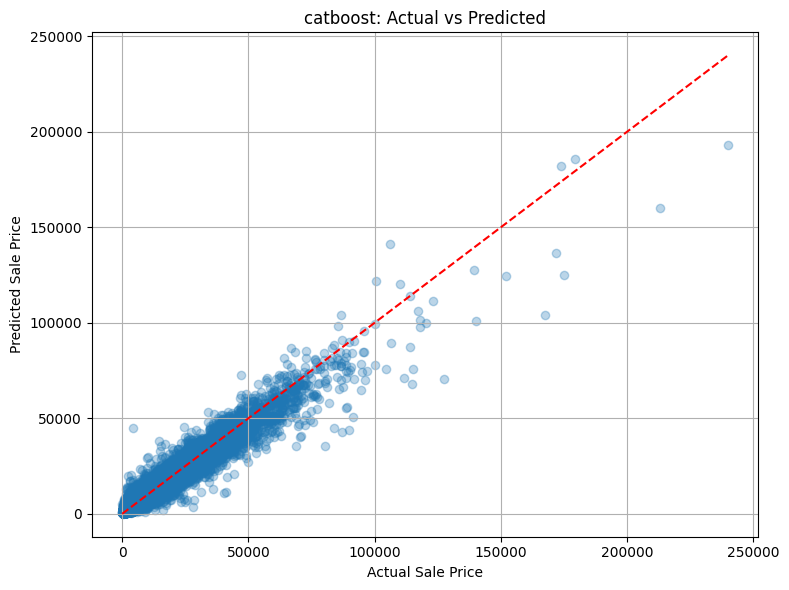

In [67]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, cat_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('catboost: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

Model Combination

In [68]:
import optuna
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import cross_val_score

In [69]:
# Define the base models with fixed parameters
catboost_model = CatBoostRegressor(
    iterations= 300,
    learning_rate= 0.07970813993595934,
    depth= int(10.0),
    rsm= 0.7660893833138341,
    l2_leaf_reg= 0.6193707955150439,
    random_strength = 1.3242384708136643,
    min_data_in_leaf = 1,
    subsample = 0.9769453707501106,
    bootstrap_type = 'Bernoulli',
    loss_function='RMSE',
    verbose=0,
    random_state=42
)

xgb_model =   XGBRegressor(
    # fixed hyperparameters from BayesOpt:
    max_depth=10,
    learning_rate=0.23015076823900443,
    subsample=0.8341201918831133,
    colsample_bytree=0.5765376867979625,
    gamma=4.185277055066359,
    min_child_weight=8,
    reg_alpha=0.7044268055679584,
    reg_lambda=3.8722650249047175,
    # keep the rest as before:
    objective='reg:squarederror',
    eval_metric='rmse',
    use_label_encoder=False,
    random_state=0,
    n_estimators=200,
    n_jobs=-1
)

In [70]:
# import subprocess
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# def objective(trial):
#     meta_params = dict(
#         n_estimators     = trial.suggest_int('meta_n_estimators', 25, 300),
#         max_depth        = trial.suggest_int('meta_max_depth', 2, 8),
#         learning_rate    = trial.suggest_float('meta_learning_rate', 1e-3, 0.2, log=True),
#         subsample        = trial.suggest_float('meta_subsample', 0.5, 1.0),
#         colsample_bytree = trial.suggest_float('meta_colsample_bytree', 0.5, 1.0),
#         reg_alpha        = trial.suggest_float('meta_reg_alpha', 0.0, 5.0),
#         reg_lambda       = trial.suggest_float('meta_reg_lambda', 0.0, 10.0),
#         objective        = 'reg:squarederror',
#         eval_metric      = 'rmse',
#         random_state     = 42,
#         n_jobs           = -1
#     )

#     stack = StackingRegressor(
#         estimators=[('Cat', catboost_model), ('xgb', xgb_model)],
#         final_estimator=XGBRegressor(**meta_params),
#         passthrough=False,     # keep fixed unless you want to tune it too
#         n_jobs=-1              # sklearn >=1.4
#     )

#     pipe = Pipeline([
#         ('preproc', preprocessor),
#         ('stack',   stack)
#     ])

#     scores = cross_val_score(pipe, X_train, y_train,
#                              cv=kf, scoring='r2', n_jobs=-1)
#     return scores.mean()

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50, show_progress_bar=True)

# print("Best R²:", study.best_value)
# print("Best params:", study.best_params)

# # # ---- Refit best model on full train ----
# # best = study.best_params
# # best_meta = XGBRegressor(
# #     n_estimators     = best['meta_n_estimators'],
# #     max_depth        = best['meta_max_depth'],
# #     learning_rate    = best['meta_learning_rate'],
# #     subsample        = best['meta_subsample'],
# #     colsample_bytree = best['meta_colsample_bytree'],
# #     reg_alpha        = best['meta_reg_alpha'],
# #     reg_lambda       = best['meta_reg_lambda'],
# #     objective        = 'reg:squarederror',
# #     eval_metric      = 'rmse',
# #     random_state     = 42,
# #     n_jobs           = -1
# # )

# # final_stack = StackingRegressor(
# #     estimators=[('Cat', catboost_model), ('xgb', xgb_model)],
# #     final_estimator=best_meta,
# #     passthrough=False,
# #     n_jobs=-1
# # )

# # final_pipeline = Pipeline([
# #     ('preproc', preprocessor),
# #     ('stack',   final_stack)
# # ]).fit(X_train, y_train)

# # y_pred = final_pipeline.predict(X_test)

In [71]:
# 3) Build the stacking regressor
stack = StackingRegressor(
    estimators=[
        ('Cat',  catboost_model),
        ('xgb', xgb_model)
    ],
    final_estimator=XGBRegressor(
        n_estimators=50,
        learning_rate=0.1,
        random_state=42
    ),
    # passthrough=True  # if you want the original features concatenated to meta‑features
)

# 4) Put it all in one pipeline
stacking_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('stack',   stack)
])

stacking_pipeline_ttr = with_log_target(stacking_pipeline)

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = cross_val_score(
#     stacking_pipeline,
#     X_train,
#     y_train,
#     cv=kf,
#     scoring="r2",
#     n_jobs=-1,
#     verbose=1
# )
# print("5-Fold CV R² scores:", cv_scores)
# print("Mean CV R²: {:.4f} ± {:.4f}".format(cv_scores.mean(), cv_scores.std()))
# #print("Stacked R²:", r2_score(y_test, y_pred))

In [72]:
# 5) Fit & evaluate
stacking_pipeline_ttr.fit(X_train, y_train)
y_pred = stacking_pipeline_ttr.predict(X_test)
y_pred_external = stacking_pipeline_ttr.predict(X_external)

In [73]:
y_r2 = r2_score(y_test, y_pred)
y_mae = mean_absolute_error(y_test, y_pred)
y_mse = mean_squared_error(y_test, y_pred)
y_rmse = np.sqrt(y_mse)
y_mape = mean_absolute_percentage_error(y_test, y_pred)

# Display results
print("📊 stack Regression Evaluation Metrics")
print(f"R² Score  : {y_r2:.4f}")
print(f"MAE       : {y_mae:.2f}")
print(f"MSE       : {y_mse:.2f}")
print(f"RMSE      : {y_rmse:.2f}")
print(f"MAPE      : {y_mape:.2%}")

📊 stack Regression Evaluation Metrics
R² Score  : 0.9293
MAE       : 1685.58
MSE       : 9624790.00
RMSE      : 3102.38
MAPE      : 28.25%


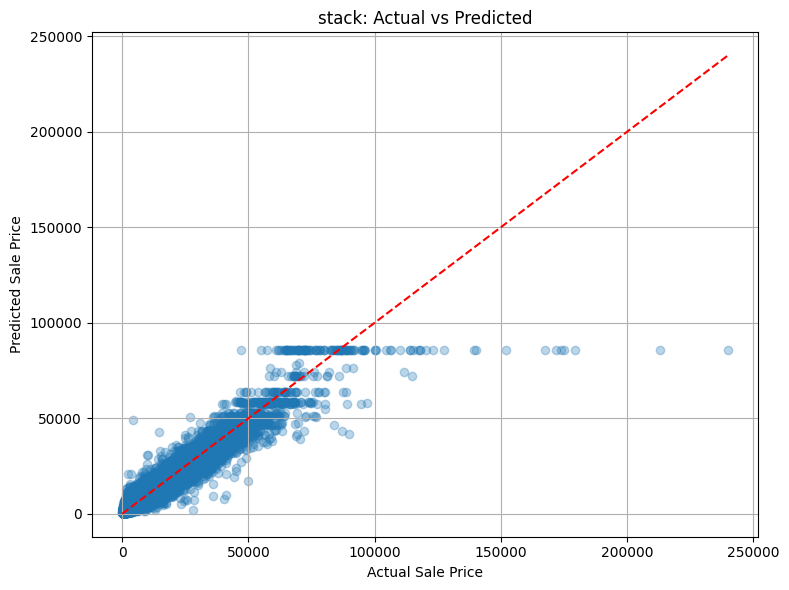

In [74]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('stack: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

Visualize the actual prices and Predicted prices

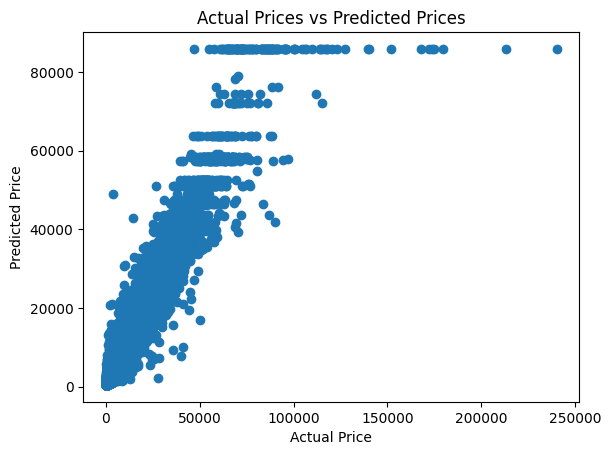

In [75]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Prices vs Predicted Prices")
plt.show()

Final Model Evaluation

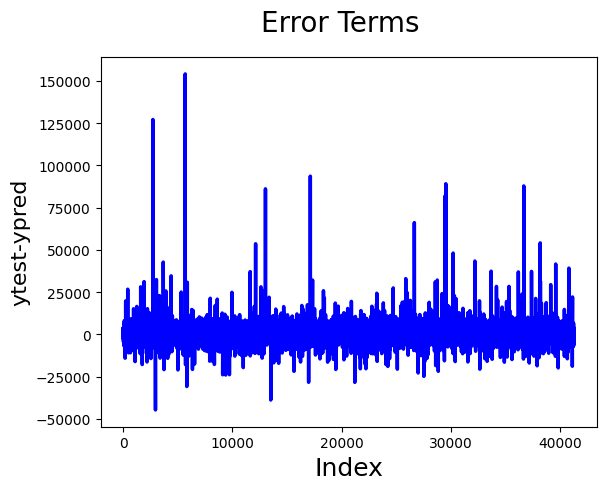

In [76]:
# Error terms
c = [i for i in range(len(y_pred))]
fig = plt.figure()
plt.plot(c,y_test-y_pred, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)                # Y-label
plt.show()

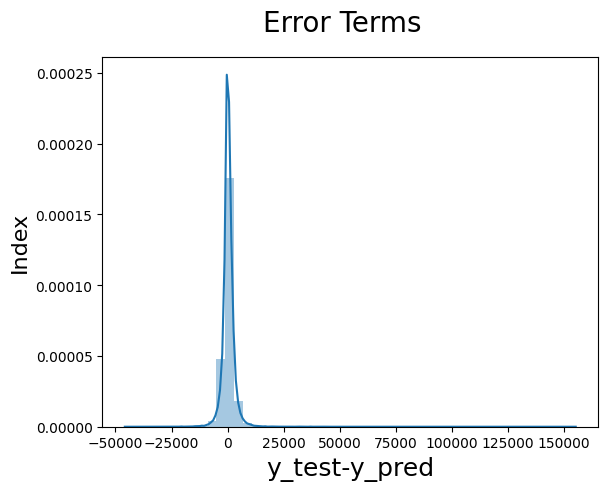

In [77]:
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label
plt.show()

Export the Predictions

In [78]:
# 1) Extract the true y values for X_external
y_external = cars_test['VRSALEAMT']

# 2) Compute R² for each model
r2_xgb      = r2_score(y_external, xgb_predictions_external)
r2_catboost = r2_score(y_external, catboost_preds_external)
r2_Cat_Native = r2_score(y_external, cat_preds_external)
r2_stack    = r2_score(y_external, y_pred_external)

# 3) Print results
print(f"XGBoost external R²:      {r2_xgb:.4f}")
print(f"CatBoost external R²:     {r2_catboost:.4f}")
print(f"CatBoost Native R²:     {r2_Cat_Native:.4f}")
print(f"Stacked model external R²:{r2_stack:.4f}")

XGBoost external R²:      0.9218
CatBoost external R²:     0.8799
CatBoost Native R²:     0.9113
Stacked model external R²:0.8777


In [79]:
# # Create a DataFrame with the original prices and the predicted sales prices
# result_df = pd.DataFrame({
#     'SoldPrice': y_test,  # Original prices from y_test
#     'XGB_Predictions': xgb_predictions,
#     'RF_Predictions': rf_predictions,
#     'Stacked_Predictions': y_pred
# })
1
result_df = pd.DataFrame({
    'XGB_Predictions': xgb_predictions_external,
    'CatBoost_Predictions': catboost_preds_external,
    'CatBoost_Native_Predictions': cat_preds_external,
    'Stacked_Predictions': y_pred_external
})

final_df = pd.concat([cars_test_original.reset_index(drop=True), result_df.reset_index(drop=True)], axis=1)

# Export the DataFrame to a CSV file
final_df.to_excel('AAA Test.xlsx', sheet_name='sheet 1', index=False)